# Import Modules

In [1]:
# fix division
from __future__ import division

# load required modules
from ldm.settings import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Global Setup

## File and Folder Structure

It is recommended to keep a well defined structure for all experimental data and the subsequent analysis data. If the answer to "nested or flat" is unclear, flat is mostly the better way to go. An example of a structure system is given by:

![Alt text](doc/graphics/experimental_folder_structure.jpg)

The default setup of this notebook aims at that structure.

### Set-up Paths and Files
Here are two paths and a suffix are defined. The first path (1) is the base-path which refers to the directory where the files of the current experiment are stored in the format shown above. The save-path (2) is the path where all analysis files are exported into. And lastly, a suffix can be defined (3) which refers to this particular analysis run: meaning if for example, many analyses are performed from that same data set or if different settings want to be compared with each other, they can be indexed using this suffix. By default there is no suffix.

In [2]:
# ===========================================================================================
# common for all mts ua folders
mts_ps_addendum = dict( sensor_file_sub_path     = 'mts/ps_monotonic.dat',
                        images_folder_sub_path   = 'veddac', 
                        ftype                    = 'bmp', 
                        geometry_file_sub_path   = 'geometry.dat')

# Set basic filter for selection of experiments: !!! EDIT HERE !!!
exp_paths     = glob.glob('/home/rhopf/temp/raphi/M_PS*')
# ===========================================================================================

# prepare dict for selection box
exp_bases     = [os.path.basename(path) for path in exp_paths]
options_paths = {basename : dict(basepath=path, **mts_ps_addendum) for basename, path in zip(exp_bases, exp_paths)}

# selection box
exp_paths = widgets.Select()
exp_paths.options = options_paths
display(exp_paths)

In [3]:
# (1) Select experiment type
exp_type_sel = widgets.Select()
exp_type_sel.options = options_type
display(exp_type_sel)

In [23]:
# make class instance for paths
Paths = ldm_loaders.Paths(**exp_paths.value)

# (2) path to save analysis files into
savepath = os.path.join(os.sep.join(Paths.basepath.split(os.sep)[:-1]), 'analysis')

# (3) analysis suffix (e.g. for different cycles, or simply for investigations like non homogeneity etc.)
suffix = 'final'

# (4) camera settings (optional parameter for rigig body motion evaluation)
mm_per_pixel = 0.03

# (5) which is the main/tensile direction on the image (horizontal, vertical)?
#     in biaxial/inflation tests, this simply corresponds to the direction,
#     which gets the axis label 'x'
#     SOMETHING IS INCONSISTENT STILL.
main_direction = 'vertical'

# (6) Clamping distance
L_clamp = 10.0

# set type
exp_type = exp_type_sel.value

# load all data
exp    = ldm_loaders.load_experiment('mts_one_axis', Paths)
cflag, rflag = True, True

if suffix is not '':
    exp_name = exp['name'] + '_' + suffix
else:
    exp_name = exp['name']

# make alternative representation of the name using escape symbols for matplotlib
exp_name_esc = '\_'.join(exp_name.split('_'))

# print summary
print 'Analysis name:\t\t', exp_name
print 'Loaded parameters:\t'
for key in exp.keys():
    print '\t\t\t' + key
    
# check and make folders
if not os.path.exists(savepath):
    os.makedirs(savepath)

# configuration path
configpath = os.path.join(savepath, exp_name + '_config')
if not os.path.exists(configpath):
    os.makedirs(configpath)
    
# add paths to dict
exp['configpath'] = configpath
exp['savepath']   = savepath

Analysis name:		M_PS_FM457_0_testday2_sp2_final
Loaded parameters:	
			n_sen
			n_img
			time_sen
			name
			frames
			force
			cs_area_ref
			time_img
			displ


### Store and Calculate Further Quantities

In [24]:
# extras
exp['main_direction'] = main_direction
exp['mm_per_pixel']   = mm_per_pixel
exp['L_clamp']        = L_clamp

# global strains
exp['epsx_glob'] = exp['displ']/L_clamp
exp['epsy_ico_glob'] = np.ones((len(exp['epsx_glob'])))
exp['epsz_ico_glob'] = 1/(exp['epsx_glob'] + 1) - 1

# crossection
exp['cs_area_glob_def'] = exp['cs_area_ref']/(exp['epsx_glob']+1)

# stresses
exp['sigx_pk1_glob'] = exp['force']/exp['cs_area_ref']
exp['sigx_cau_glob'] = exp['force']/exp['cs_area_glob_def']

##Crop Experiment
Here are the experiment can be cropped, such that all other data is ignored in any further analysis steps. For example single load cycles can be selected and analyzed conveniently.

Cropped data is **not manipulated further** in the `exp` dict.

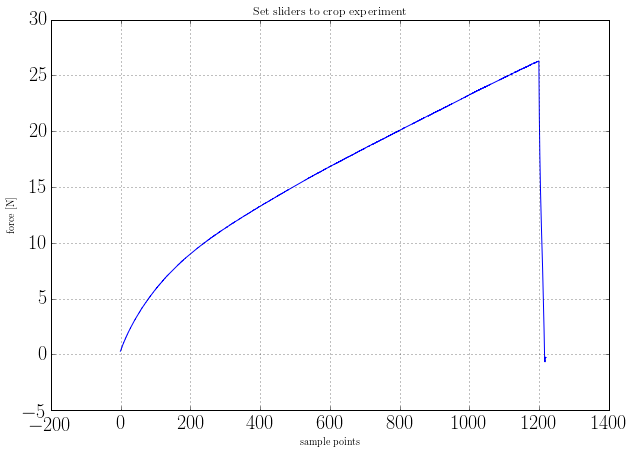

In [25]:
w_exp, exp = ldm_prc.inter(action='crop_exp', exp=exp)
display(w_exp)

In [26]:
if cflag:
    # subsequent indices for cropping
    idx_sen_start  = w_exp.kwargs['idx_sen_start']
    idx_sen_end    = w_exp.kwargs['idx_sen_end']
    idx_img_start  = np.argmin(np.abs(exp['time_img'] - exp['time_sen'][idx_sen_start]))
    idx_img_end    = np.argmin(np.abs(exp['time_img'] - exp['time_sen'][idx_sen_end]))

    # trim data and frames list
    exp = ldm_prc.cut_data(idx_sen_start, idx_sen_end, idx_img_start, idx_img_end, exp)
    exp['frames'] = exp['frames'][idx_img_start:idx_img_end]

    # save file for cropping
    np.savetxt(exp['fname_crop'], [idx_sen_start, idx_sen_end], fmt='%i')
    
    # trimming done
    cflag = False

else:
    print 'This data has already been cropped. Please reload data if a new cropping is required.'

## Find Reference Configuration
Please check out the corresponding notes [here](doc/find_reference.pdf). Then run the next cell and make sure that the drop-down box is selected to the method you would like to use. 

### Select Window

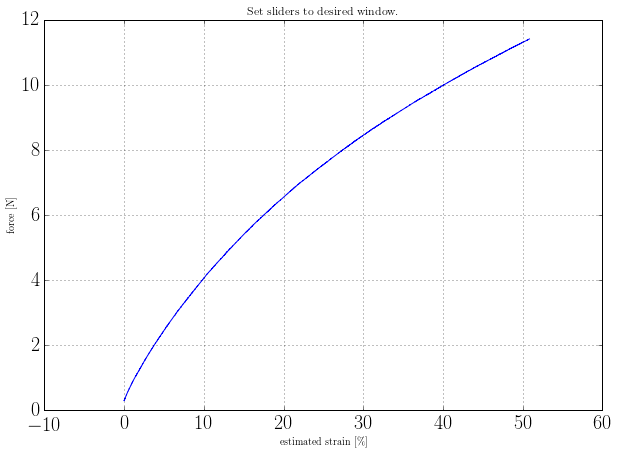

In [27]:
# set sliders to crop the transition area
ref_method = ldm_ref.select_reference_method()
w_ref, exp = ldm_prc.inter(action='crop_ref', exp=exp)
display(w_ref)

### Run Method

Reference index found at: 1
Force at reference: 	f_min = 0.289678635
Relative value: 	f_rel = 1.10162121393 %


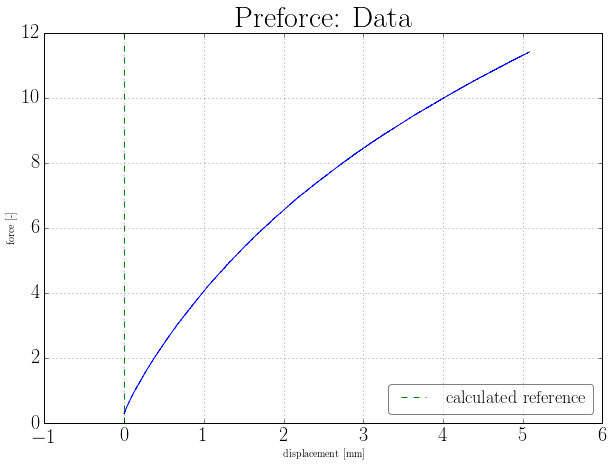

In [28]:
# preforce has no effect, unless the method is selected
preforce = -0.035

# from sliders
w_start = int(w_ref.kwargs['idx_sen_start'])   # index to start looping (window)
w_end   = int(w_ref.kwargs['idx_sen_end'])     # index to end looping (window)

# check for existing file
fname_r = os.path.join(configpath, 'preforce.dat')

if os.path.exists(fname_r):
    if input('A preforce has already been determined. Do you want to overwrite? (0/1)'):
        # recompute reference
        idx_sen_ref, fig   = ldm_ref.get_reference(ref_method.value, exp['displ'], exp['force'], w_start, w_end, preforce)
        preforce_eff       = exp['force'][idx_sen_ref]
        preforce_eff_level = 100*exp['force'][idx_sen_ref]/exp['force'].max()
        
    else:
        preforce_eff       = float(np.loadtxt(fname_r))
        idx_sen_ref, fig   = ldm_ref.get_reference(0, exp['displ'], exp['force'], w_start, w_end, preforce_eff)
        preforce_eff_level = 100*exp['force'][idx_sen_ref]/exp['force'].max()
        
else:
    # compute reference
    idx_sen_ref, fig   = ldm_ref.get_reference(ref_method.value, exp['displ'], exp['force'], w_start, w_end, preforce)
    preforce_eff       = exp['force'][idx_sen_ref]
    preforce_eff_level = 100*exp['force'][idx_sen_ref]/exp['force'].max()
    
print 'Force at reference: \tf_min =', preforce_eff
print 'Relative value: \tf_rel =',     preforce_eff_level, '%'

### Experiment Type: Adjust Tail

In [29]:
if exp_type == 'cycle':
    # check for closest value of preforce at tail
    idx_sen_ref_tail = exp['n_sen'] - np.argmin(np.abs(exp['force'][:int(exp['n_sen']/2.0):-1] - preforce_eff))

elif exp_type == 'loading':
    # check maximum
    idx_sen_ref_tail = np.argmax(exp['force'])
    
else:
    idx_sen_ref_tail = -1

### Adjust and Save Data

Forces and displacement are interpolated as shown [here](doc/graphics/strain_interpolation.pdf).

In [30]:
if rflag:
    # find real start frame and corresponding indices in images
    idx_sen_start  = idx_sen_ref
    idx_sen_end    = idx_sen_ref_tail + 1
    idx_img_start  = np.argmin(np.abs(exp['time_img'] - exp['time_sen'][idx_sen_ref]))
    idx_img_end    = np.argmin(np.abs(exp['time_img'] - exp['time_sen'][idx_sen_ref_tail])) + 1

    # trim data and frame list
    exp['time_sen'] = exp['time_sen'][idx_sen_start:idx_sen_end]
    exp['time_img'] = exp['time_img'][idx_img_start:idx_img_end]
    exp = ldm_prc.cut_data(idx_sen_start, idx_sen_end, idx_img_start, idx_img_end, exp)
    exp['frames'] = exp['frames'][idx_img_start:idx_img_end]
    
    # reset force to zero at reference
    exp['force']    = exp['force'] - exp['force'][0]

    # time that corresponds to strain measurements ("between frames") and first increment
    strain_time = (exp['time_img'][1:] + exp['time_img'][:-1])/2.0
    strain_time = np.insert(strain_time, 0, 0)
    
    # interpolate all data to strain time
    exp = ldm_prc.ip_data(strain_time, exp)
    
    # reset both times: zero
    exp['time_sen'] = exp['time_sen'] - exp['time_sen'][0]
    exp['time_img'] = exp['time_img'] - exp['time_img'][0]
    
    # recompute stress and strain
    exp['L_clamp_corr']     = L_clamp + exp['displ'][0]
    exp['epsx_glob']        = (exp['displ'] - exp['displ'][0]) / exp['L_clamp_corr']
    exp['epsy_ico_glob']    = 1/np.sqrt(exp['epsx_glob'] + 1) - 1
    exp['epsz_ico_glob']    = 1/np.sqrt(exp['epsx_glob'] + 1) - 1
    exp['cs_area_glob_def'] = exp['cs_area_ref']/(exp['epsx_glob']+1)
    exp['sigx_pk1_glob']    = exp['force']/exp['cs_area_ref']
    exp['sigx_cau_glob']    = exp['force']/exp['cs_area_glob_def']

    # SAVE: preforce, image time and force
    fname_f = os.path.join(configpath, 'force.dat')
    fname_t = os.path.join(configpath, 'time.dat')
    np.savetxt(fname_f, exp['force'])
    np.savetxt(fname_t, strain_time)
    np.savetxt(fname_r, [preforce_eff])

    print 'First frame: ' + os.path.basename(exp['frames'][0])
    
    # trimming and interpolation done
    rflag = False
    
else:
    print 'This data has already been trimmed to reference. Please reload data if a new reference is required.'

First frame: 01000001.bmp


# Optical Flow Tracking

## Tracker Setup
Here, some settings for the corner detection and optical flow tracking can be modified. For the corner detection, the quality level can be adjusted between zero and one in order to increase or decrease the amount of detected points.

For the tracker, the window size determines a rectangle which is used to find the optical flow between two images. The maximum level indicates the number of pyramids (=in size reduced copies of the original image) used to track the images. This can be crucial if points between images take huge leaps at once (fast motion). However, sometimes it can happen that points completely loose their track from one image to another. The reason could be that the amount of pyramids is too big and by compressing the image, similar features further away are matched incorrectly. So it is advisable to keep this number as low as possible. For most quasi static experiments, a value of 1 or 2 seems to yield very stable results.

In [31]:
detect_features = RadioButtons(description='Use Corner Detection?',     options=['Yes', 'No'])
marker_mode     = RadioButtons(description='Set marker creation mode:', options=[r'Rectangle', 
                                                                                 r'Circle (Center/Radius)',
                                                                                 r'Circle (3 Points)',
                                                                                 r'Manual'])
display(detect_features)
display(marker_mode)

In [32]:
# window block size (in case of doubt the default values of 5 to 10 often provides excellent results)
block = 6

# general setup for marker creation
setup_params    = dict( m_spacing       = 10,         # only active if corner detection is deactivated
                        n_spacing       = 10,         # only active if corner detection is deactivated
                        r_scaler        = 0.20)       # radius scaling, for 3-point circles only

# parameters for Shi-Tomasi corner detection
feature_params  = dict( maxCorners   = 100000,
                        qualityLevel = 0.025,
                        minDistance  = 5,
                        blockSize    = block,)

# parameters for lucas kanade optical flow
tracker_params  = dict( winSize  = (block, block),
                        maxLevel = 3,
                        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

## Select Area

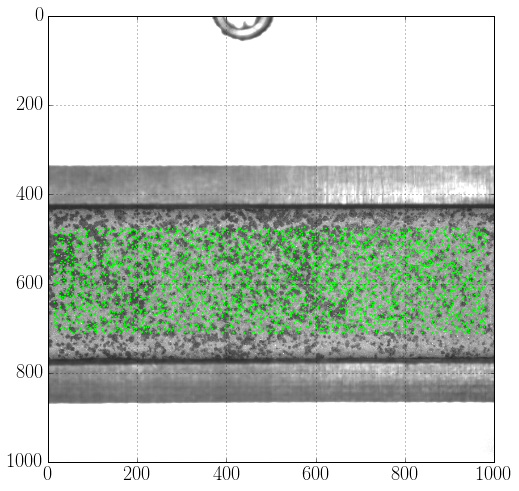

In [33]:
# ensure qt
%matplotlib qt

# update dict
setup_params['marker_mode']     = marker_mode
setup_params['detect_features'] = detect_features

marker_scaffold, img_old = ldm_trk.set_marker_area(exp['frames'], **setup_params)

# ensure inline
%matplotlib inline

p0 = ldm_trk.set_markers(marker_scaffold, exp['frames'], feature_params, **setup_params)

## Run Tracker
The track coordinates are automatically saved as numpy binary array files into the corresponding directory. This way, the full tracking data can be accessed at the later point, without having to redo the tracking.

In [34]:
# track it
coords = ldm_trk.run_tracker(exp['frames'], p0, tracker_params)

# save coords as numpy binary file
c_file = os.path.join(configpath, 'coords')
np.save(c_file, coords)

Nr. of points discarded: 0


# Postprocessing

In [35]:
# process coordinates
epsx, epsy, evecs, rb_angle, rb_transl, residuals = ldm_prc.process_coordinates(coords, main_direction, mm_per_pixel)

# add to dict
exp['epsx_loc']     = epsx
exp['epsy_loc']     = epsy

# evecs, rbm, coords, center and residuals
exp['coords']    = coords
exp['residuals'] = residuals
exp['rbm']       = dict(rot=rb_angle, transl=rb_transl)
exp['evecs']     = evecs
exp['center']    = coords.mean(axis=1)

# make a copy of exp
exp_unfiltered   = exp.copy() 

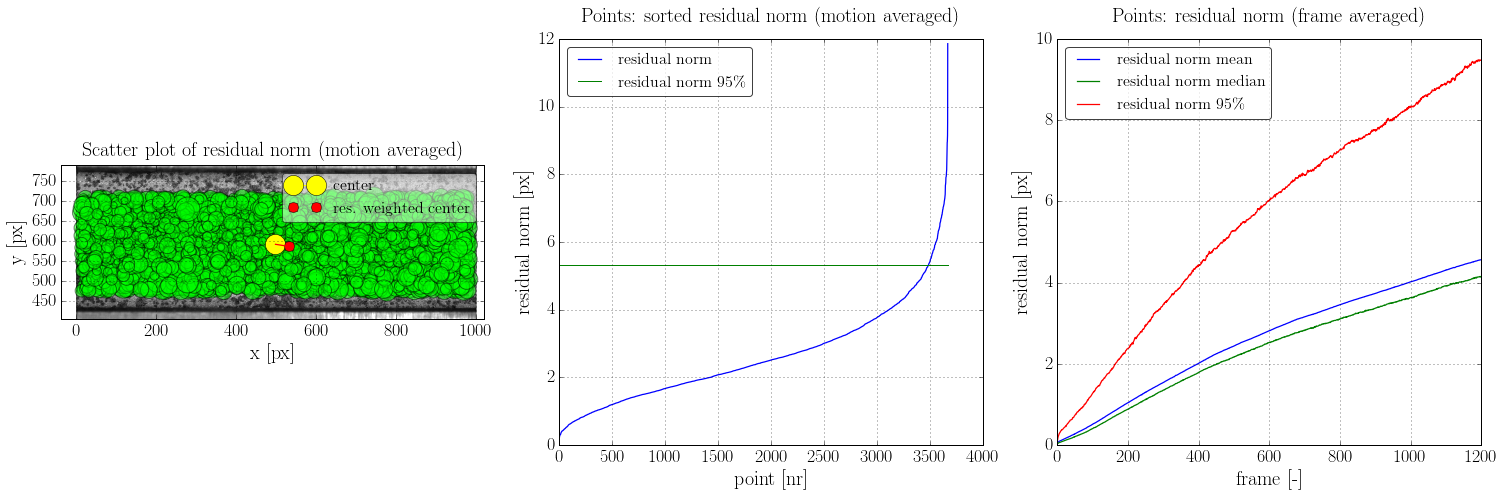

In [36]:
# check homogeneity
section = ldm_dpl.plot_homogeneity(exp_unfiltered, pct=95, pts=None)

## Filter Non-Homogenous Motion

**Assumption**: Affine motion dominates, such that "faulty" trackers exhibit the highest errors.

In [37]:
exp = ldm_prc.percentile_filter_coords(exp_unfiltered.copy(), level=1.0, pct=75)

Iter nr. 1 	Points deleted: 918 	Points remaining: 3670 	Max. res.: 11.86 	 Global affinity: 34.615
Iter nr. 2 	Points deleted: 688 	Points remaining: 2752 	Max. res.: 3.76 	 Global affinity: 12.198
Iter nr. 3 	Points deleted: 516 	Points remaining: 2064 	Max. res.: 2.76 	 Global affinity: 7.627
Iter nr. 4 	Points deleted: 387 	Points remaining: 1548 	Max. res.: 2.18 	 Global affinity: 2.636
Iter nr. 5 	Points deleted: 290 	Points remaining: 1161 	Max. res.: 1.86 	 Global affinity: 0.754
Iter nr. 6 	Points deleted: 218 	Points remaining: 871 	Max. res.: 1.61 	 Global affinity: 1.91
Iter nr. 7 	Points deleted: 163 	Points remaining: 653 	Max. res.: 1.34 	 Global affinity: 2.143
Iter nr. 8 	Points deleted: 123 	Points remaining: 490 	Max. res.: 1.19 	 Global affinity: 1.925
Iter nr. 9 	Points deleted: 92 	Points remaining: 367 	Max. res.: 1.07 	 Global affinity: 1.978
Iter nr. 10 	Points deleted: 69 	Points remaining: 275 	Max. res.: 0.95 	 Global affinity: 2.193


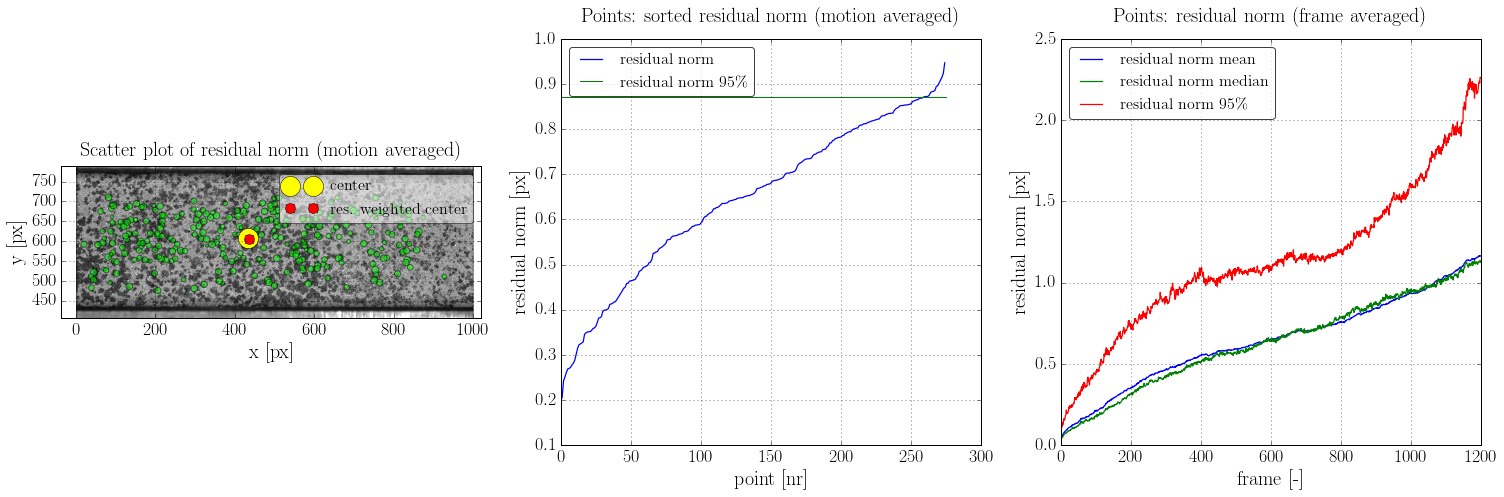

In [38]:
# check homogeneity
section = ldm_dpl.plot_homogeneity(exp, pct=95, pts=section)

##PureShear Incompressible

Since for incompressible materials $\mathrm{det}\left(\mathbf{F}\right)=\lambda_{1}\lambda_{3}=\lambda\lambda_{T}=1$ holds, the transverse strain for the remaining axis ($z$) is expressed by: $$\varepsilon_{T}=\frac{1}{\varepsilon+1}-1$$

The calculated transverse strain should be compared to the measured strain to validate incompressibility. Note that the Cauchy stress is **only meaningful** if the measured **transverse strain** follows the **incompressibility** law.

In [39]:
# strains
exp['epsy_ico_loc'] = np.zeros(len(exp['epsx_loc']))
exp['epsz_ico_loc'] = 1/(exp['epsx_loc'] + 1) - 1

# consequence for the crossection
exp['cs_area_loc_def'] = exp['cs_area_ref']/(exp['epsx_loc'] + 1)

# resulting stresses
exp['sigx_pk1_loc'] = exp['force']/exp['cs_area_ref']
exp['sigx_cau_loc'] = exp['force']/exp['cs_area_loc_def']

# Save Data

1 file for loading and unloading (if exists) each. exp_name + 'un/loading': [`time`, `epsx_loc`, `epsy_loc`, `force`, `sigx_pk1`, `sigx_cau`]

In [40]:
if exp_type == 'cycle':
    
    # splitting index
    idx_split = np.argmax(exp['epsx_loc'])
    
    # save data
    fname_loading   = os.path.join(savepath, exp_name + '_loading.dat')
    fname_unloading = os.path.join(savepath, exp_name + '_unloading.dat')
    np.savetxt(fname_loading, np.array([exp['time_sen'][:(idx_split+1)], exp['epsx_loc'][:(idx_split+1)], exp['epsy_loc'][:(idx_split+1)], 
                                        exp['force'][:(idx_split+1)], exp['sigx_pk1_loc'][:(idx_split+1)], exp['sigx_cau_loc'][:(idx_split+1)]]).T)
    np.savetxt(fname_unloading, np.array([exp['time_sen'][idx_split:] - exp['time_sen'][idx_split], exp['epsx_loc'][idx_split:][::-1], exp['epsy_loc'][idx_split:][::-1], 
                                          exp['force'][idx_split:][::-1], exp['sigx_pk1_loc'][idx_split:][::-1], exp['sigx_cau_loc'][idx_split:][::-1]]).T)
    
elif exp_type == 'loading':
    
    # splitting index
    idx_split = np.argmax(exp['epsx_loc'])
    
    # save data
    fname_loading = os.path.join(savepath, exp_name + '_loading.dat')
    np.savetxt(fname_loading, np.array([exp['time_sen'][:idx_split], exp['epsx_loc'][:idx_split], exp['epsy_loc'][:idx_split], 
                                        exp['force'][:idx_split], exp['sigx_pk1_loc'][:idx_split], exp['sigx_cau_loc'][:idx_split]]).T)

# Plotting 

## Summary

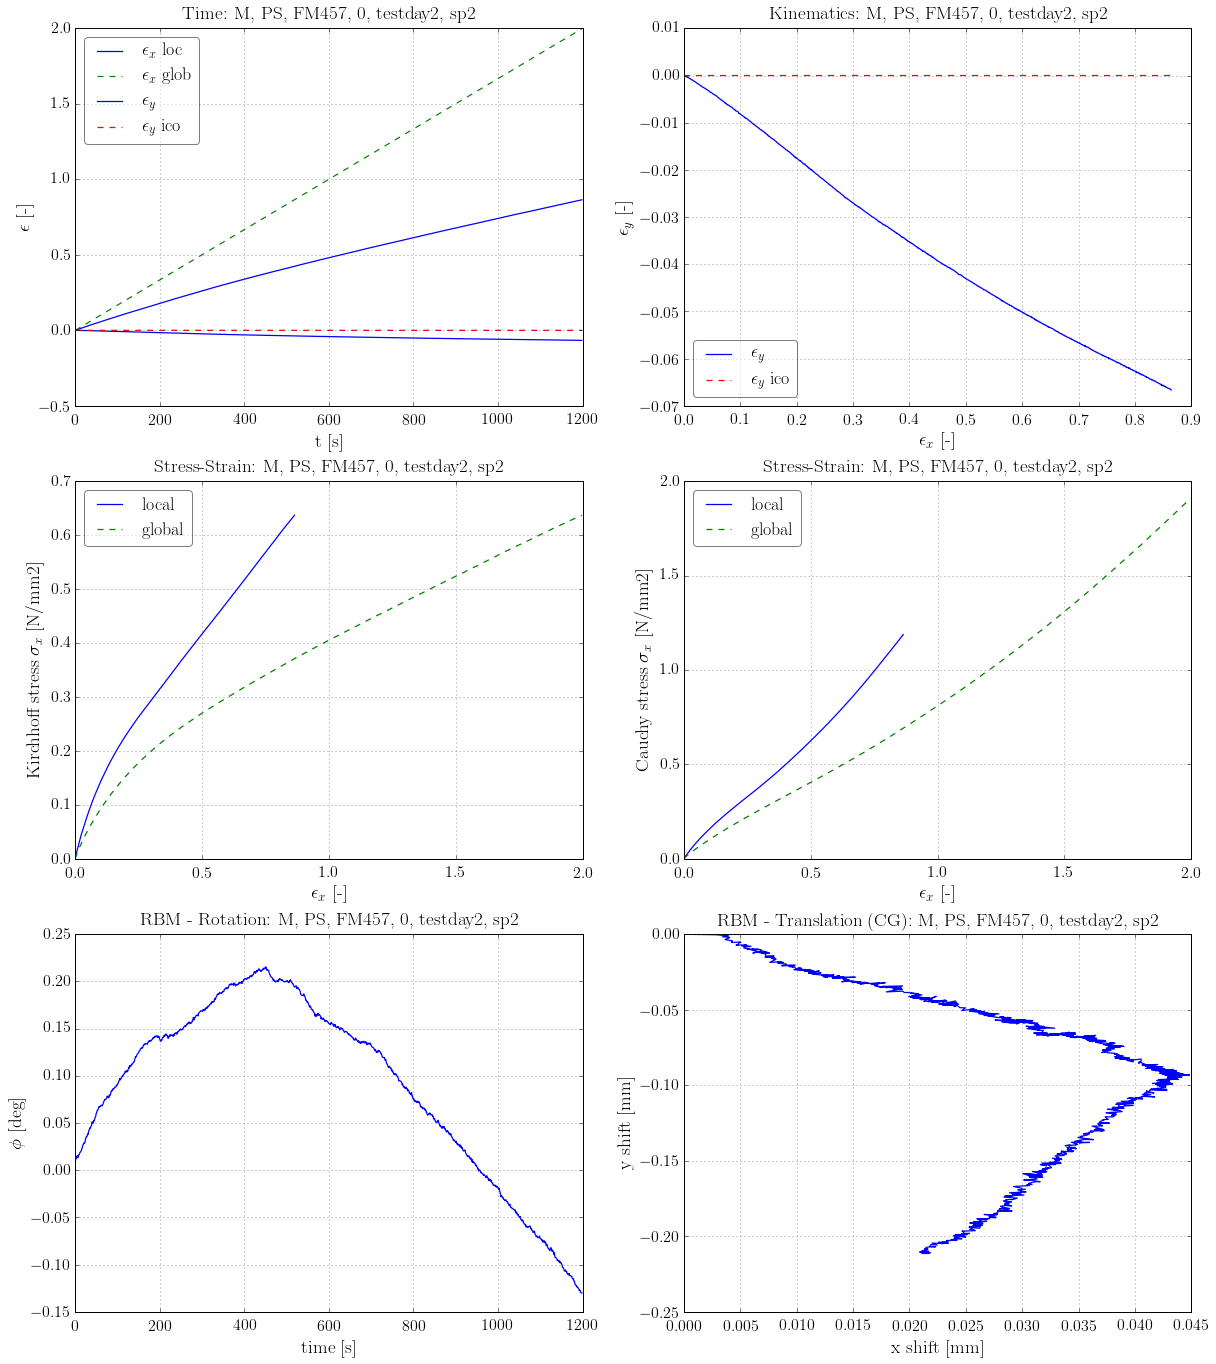

In [41]:
fig = ldm_dpl.summary_plot_ua_ico(exp, fontsize=19, labelsize=16)
fig.savefig(os.path.join(configpath, exp_name + '_loading.pdf'), bbox_inches='tight')

## Principal Directions

In [141]:
def plot_directions(n=0):
    
    v1, v2 = exp['evecs'][n].T
    v2     = (exp['epsx_loc'][n] + 1)*v2/2
    v1     = (exp['epsy_loc'][n] + 1)*v1/2
    fig = plt.figure(figsize=(8, 8))
    img = plt.imread(exp['frames'][n])
    plt.imshow(img, cmap=plt.cm.Greys_r, origin='lower')
    plt.quiver([exp['center'][n][0]],[exp['center'][n][1]], v1[0], v1[1], color='g', scale=3)
    plt.quiver([exp['center'][n][0]],[exp['center'][n][1]], -v1[0], -v1[1], color='g', scale=3)
    plt.quiver([exp['center'][n][0]],[exp['center'][n][1]], v2[0], v2[1], color='r', scale=3)
    plt.quiver([exp['center'][n][0]],[exp['center'][n][1]], -v2[0], -v2[1], color='r', scale=3)
    plt.xlim([1, 1000])
    plt.ylim([1, 1000])
    plt.axis('off')
    plt.tight_layout()

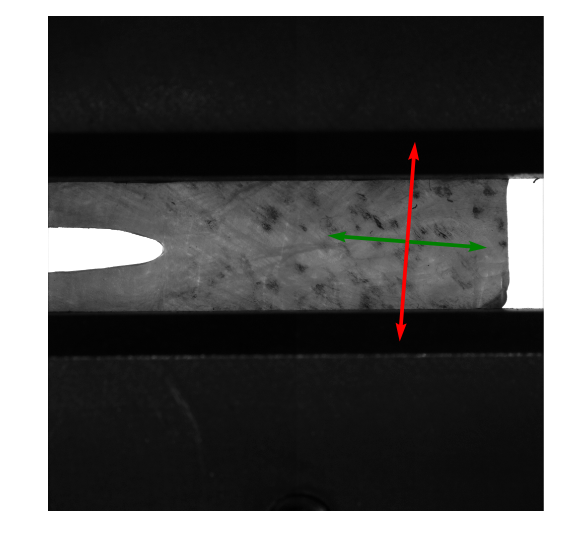

In [142]:
w = interactive(plot_directions, n=(0, len(evecs)-1, 1))
display(w)